In [2]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3


In [3]:
import deephyp.data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm
from train_objectives import SAD, SID

/home/han/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.cuda.empty_cache()

In [4]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [5]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
dataTrain = data.Iterator( dataSamples=hypData.spectraPrep[:trainSamples, :],
                        targets=hypData.spectraPrep[:trainSamples, :], batchSize=4 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
train_data = torch.tensor(dataTrain.dataSamples.astype(np.float32))
train_data

tensor([[2.7750e-01, 1.7326e-01, 1.3731e-01,  ..., 9.0870e-01, 9.1661e-01,
         9.2991e-01],
        [4.1212e-01, 3.5628e-01, 3.1991e-01,  ..., 7.9870e-01, 7.9827e-01,
         7.8788e-01],
        [4.0177e-07, 4.8216e-03, 8.7988e-02,  ..., 7.7099e-01, 7.7782e-01,
         7.8144e-01],
        ...,
        [1.3810e-01, 1.4286e-01, 2.7024e-01,  ..., 5.9524e-07, 2.3215e-02,
         1.1905e-02],
        [1.5566e-01, 9.7860e-02, 2.9970e-02,  ..., 7.2202e-01, 7.3731e-01,
         7.5474e-01],
        [1.3294e-01, 3.1536e-01, 2.7991e-01,  ..., 4.5273e-01, 4.4461e-01,
         4.6381e-01]])

In [8]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [9]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [10]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Linear(103, 50)  # 64-16-2-16-64
    self.enn2 = T.nn.Linear(50, 30)
    self.enn3 = T.nn.Linear(30,10)
    self.dnn3 = T.nn.Linear(10, 30)  # 64-16-2-16-64
    self.dnn2 = T.nn.Linear(30, 50)
    self.dnn1 = T.nn.Linear(50,103)

  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dnn3(x))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    encoded=self.encoder(x)
    decoded= self.decoder(encoded)
    
    return encoded,decoded
    
net=Net().to(device)


In [11]:

inpu=torch.rand(1,103).to(device)
outp=net(inpu)
outp[1].shape


torch.Size([1, 103])

In [12]:
hypData.numBands

103

In [13]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 1300
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = SAD()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  time.sleep(0.5)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0

  iterator = iter(train_ldr)
  
  for (batch_idx, batch) in loop:
    Z = next(iterator)
    Z = Z.view(Z.size()[0], -1)
    Z = Z.cuda()
    
    enc_out, dec_out = net(Z.float())
    loss1 = loss_func(dec_out, Z.float())  
    loss1 = torch.sum(loss1).float()
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    
    X = batch.to(device)  # no targets needed
    
    '''optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt[1], X)  # note: X not Y'''
    #loss_obj1=loss_func1(oupt[1],X)
    epoch_loss += loss1.item()  # accumulate
    #mseloss+=loss_obj1.item()
    #loss_obj.backward()
    #optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 

bat_size = 8184 
loss = SAD()
optimizer = Adam
max_epochs = 1300 
lrn_rate = 0.000 

Starting training


Epoch [418/1300]:  56%|█████▌    | 14/25 [00:57<02:11, 11.93s/it, loss=6425.217742919922]

: 

: 

In [ ]:
p=net(Z.float())
p.detach()

tensor([[-0.1088, -0.1885,  0.0855,  ..., -0.0074,  0.0270,  0.0195],
        [-0.1091, -0.1882,  0.0852,  ..., -0.0080,  0.0272,  0.0190],
        [-0.1097, -0.1873,  0.0853,  ..., -0.0049,  0.0268,  0.0175],
        ...,
        [-0.1104, -0.1867,  0.0852,  ..., -0.0040,  0.0267,  0.0162],
        [-0.1097, -0.1876,  0.0853,  ..., -0.0069,  0.0271,  0.0177],
        [-0.1106, -0.1865,  0.0854,  ..., -0.0032,  0.0264,  0.0157]],
       device='cuda:0')

In [ ]:

torch.save(net, 'model_sad.pth')

In [ ]:
torch.save(net.state_dict(), 'net_model_sad.pth')

In [ ]:
net.load_state_dict(torch.load('net_model_sad.pth'))

<All keys matched successfully>

In [ ]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
trex

tensor([[0.1428, 0.1011, 0.0913,  ..., 0.8679, 0.8727, 0.8761],
        [0.1670, 0.1465, 0.1398,  ..., 0.8144, 0.8221, 0.8447],
        [0.2236, 0.2766, 0.1961,  ..., 0.9382, 0.9538, 0.9606],
        ...,
        [0.1139, 0.0292, 0.0460,  ..., 0.8492, 0.8594, 0.8660],
        [0.1068, 0.1744, 0.1333,  ..., 0.8415, 0.8397, 0.8316],
        [0.2278, 0.1603, 0.0520,  ..., 0.8381, 0.8505, 0.8657]])

In [ ]:
dataZ=net.encoder(trex.to("cuda"))
dataZ

tensor([[0.9095, 0.0000, 0.0000,  ..., 3.1624, 0.0000, 4.2269],
        [1.0933, 0.0000, 0.0000,  ..., 3.1627, 0.0000, 4.3015],
        [1.0379, 0.0000, 0.0000,  ..., 3.3063, 0.0000, 4.1848],
        ...,
        [1.2522, 0.0000, 0.0000,  ..., 3.4875, 0.0000, 4.7604],
        [1.3364, 0.0000, 0.0000,  ..., 3.3491, 0.0000, 4.7228],
        [1.2908, 0.0000, 0.0000,  ..., 3.3046, 0.0000, 4.7423]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [ ]:
dataY = net.decoder(dataZ)
dataY

tensor([[0.1266, 0.1034, 0.0872,  ..., 0.8808, 0.8870, 0.8952],
        [0.1692, 0.1446, 0.1249,  ..., 0.8339, 0.8366, 0.8423],
        [0.2637, 0.2069, 0.1613,  ..., 0.9071, 0.9141, 0.9217],
        ...,
        [0.1045, 0.0683, 0.0420,  ..., 0.8381, 0.8441, 0.8533],
        [0.1846, 0.1323, 0.0829,  ..., 0.8224, 0.8273, 0.8351],
        [0.2110, 0.1499, 0.0860,  ..., 0.8499, 0.8547, 0.8626]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
imgZ = np.reshape(dataZ.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [ ]:
imgY = np.reshape(dataY.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [ ]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [ ]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

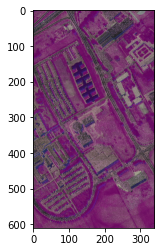

In [ ]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

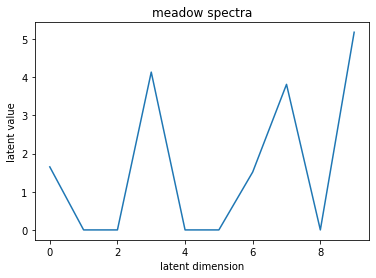

In [ ]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

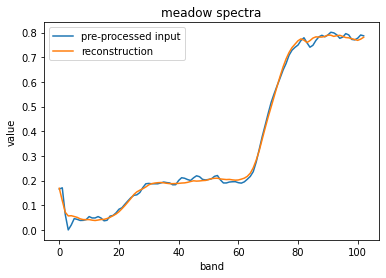

In [ ]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()